# 0) Work Directory and setup

In [2]:
import os
# Obtiene el nuevo directorio actual después del cambio
new_directory = '/Users/jyoung/Doctorado/embryo_classification/'
os.chdir(new_directory)
print("New actual directory:", new_directory)

# Elimino warnings molestas
import warnings
warnings.filterwarnings("ignore")


New actual directory: /Users/jyoung/Doctorado/embryo_classification/


# 1) Libraries

In [3]:
# Data Manipulation and Visualization
import numpy as np  # NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Matplotlib for creating visualizations
from pathlib import Path  # Pathlib for working with file paths
import openpyxl  # Openpyxl for reading and writing Excel files
import json  # JSON for data serialization
from tqdm import tqdm  # tqdm for creating progress bars
from typing import Tuple, List, Union  # Typing for type hinting in function signatures
import random

# Model Training and Evaluation
import torch  # PyTorch for tensor computations and neural network support
import torch.nn.functional as F  # Functions without parameters for neural network operations
import torchvision.transforms as T  # Image transformations and utilities for PyTorch
from torch.utils.data import Dataset  # Base class for creating custom datasets in PyTorch
import torch.nn as nn  # Neural network modules and classes to build networks
import torch.optim as optim  # Optimization algorithms in PyTorch
import torchvision.models as models  # Pretrained models and architectures in PyTorch
from sklearn.model_selection import train_test_split  # Split datasets for training and validation
import torch.optim as optim  # Optimization algorithms in PyTorch (repeated import)
from torch.utils.data import DataLoader  # Data loading utilities for PyTorch models
from torch.cuda.amp import autocast  # Automatic mixed precision training in PyTorch
from sklearn.model_selection import KFold  # K-Folds cross-validator for model evaluation


# Image Processing and Feature Extraction
from skimage import exposure  # Image exposure adjustment
from scipy import ndimage  # Multi-dimensional image processing
import skimage.measure  # Image measurement and analysis
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Image preprocessing using Keras
from PIL import Image  # Python Imaging Library for image processing

# Signal Processing
from scipy.signal import find_peaks, savgol_filter  # Signal processing functions in SciPy
import cv2  # OpenCV for computer vision tasks


2024-01-14 17:24:43.934420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2) Functions

## Image functions

In [4]:
def load_image(region: str, index: int) -> np.ndarray:
    """
    Loads and preprocesses an image from a specified region and index.

    Parameters:
    - region (str): Name of the region.
    - index (int): Index of the image.

    Returns:
    - chosen_region (np.ndarray): Preprocessed image.
    """
    chosen_region = img_to_array(load_img(str(region) + '/' + str(index) + '.bmp', grayscale=True)).squeeze() / 255.0
    return chosen_region


def plot_sample_image(index: int, dataset : Dataset) -> None:
    """
    Plots a sample image and its label from the dataset.

    Args:
    - index (int): Index of the image in the dataset to be plotted.
    - dataset: The dataset object containing the images and labels.

    Returns:
    - None
    """
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))

    for i in range(3):
        imagen, label = dataset.__getitem__(index)
        imagen = np.swapaxes(imagen, 0, 2)
        label = convert_to_text(label)
        axes[i].imshow(imagen)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## Training functions

In [5]:
def train_one_epoch(model : torch.nn.Module,
                    optimizer : torch.optim.Optimizer,
                    data_loader : torch.utils.data.DataLoader,
                    device : str,
                    dtype : type = torch.float32,
                    scaler : torch.cuda.amp.GradScaler = None ) -> Tuple[float, float]:
    """
    Trains the model for one epoch using the provided data_loader.

    Args:
    - model: The neural network model to be trained.
    - optimizer: The optimizer used for training the model.
    - data_loader: The data loader providing training data.
    - device: The device on which the training will be performed (e.g., 'cpu' or 'cuda').
    - dtype (torch.dtype, optional): The data type used for the tensors (default: torch.float32).
    - scaler (torch.cuda.amp.GradScaler, optional): Gradient scaler for mixed precision training (default: None).

    Returns:
    - tuple: A tuple containing the average loss per sample and the accuracy for the epoch.
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)
        optimizer.zero_grad()
        with autocast(enabled=(scaler is not None)):
            scores = model(x)
            loss = F.cross_entropy(scores, y)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        _, predicted = scores.max(1)
        correct += (predicted == y).sum().item()
        total_samples += x.size(0)

    return total_loss / total_samples, correct / total_samples


def accuracy(loader: torch.utils.data.DataLoader,
            model : torch.nn.Module,
            device : str,
            dtype : type = torch.float32) -> float:
    """
    Calculates accuracy on a given data loader using the provided model.

    Args:
    - loader: The data loader to calculate accuracy on.
    - model: The neural network model to evaluate.
    - device: The device on which the evaluation will be performed (e.g., 'cpu' or 'cuda').
    - dtype (torch.dtype, optional): The data type used for the tensors (default: torch.float32).

    Returns:
    - float: The accuracy of the model on the given data loader.
    """
    print(f'Checking accuracy')

    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)

            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)
        
        accuracy = num_correct / num_samples if num_samples > 0 else 0
        print(f'Got {num_correct} / {num_samples} correct ({100 * accuracy:.2f}%)')
    
    return accuracy


def get_pretrained_model(model_name: str) -> torch.nn.Module:
    """
    Loads a pre-trained model based on the specified model name.

    Args:
    - model_name (str): The name of the pre-trained model ('vgg16', 'resnet50', 'inceptionv3', or 'mobilenetv2').

    Returns:
    - torch.nn.Module: The pre-trained model specified by the model_name.
    """
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model_name == 'inceptionv3':
        model = models.inception_v3(pretrained=True)
    else:
        raise ValueError('Model not recognized. Choose from vgg16, resnet50, inceptionv3, or mobilenetv2')
    
    return model




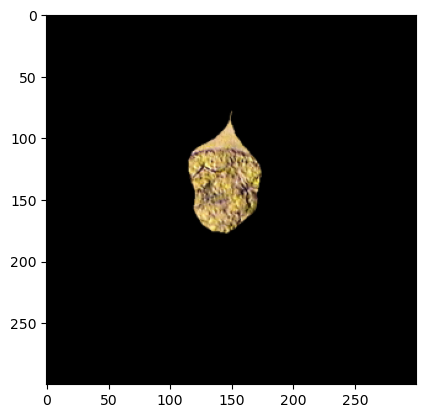

In [76]:
InstancedEmbryoDataset = EmbryoDataset(img_dir, y, True, 'ICM')
figurita, _ = InstancedEmbryoDataset.__getitem__(0)
plt.imshow(torch.swapaxes(figurita,0,2))

## Dataset functions

In [77]:
class EmbryoDataset(Dataset):
    def __init__(self, img_dir, labels, region_specific=False, region=None):
        self.img_labels = labels  # Store the image labels
        self.img_dir = img_dir  # Store the directory containing the images
        self.region_specific = region_specific
        if region_specific:
            self.region = region
            self.mask_dir = 'data/BlastsOnline/GT_' + region

        # Define a series of image transformations using torchvision's Compose
        self.transform = T.Compose([
            T.Pad(100, padding_mode='reflect'),  # Padding the images
            T.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a 50% probability
            T.RandomRotation(degrees=(0, 350), fill=100),  # Randomly rotate the image between -10 and 10 degrees
            T.Resize((400, 400)),  # Resize the image to (400, 400)
            T.CenterCrop(300),  # Center crop the resized image to a final size of (300, 300)
            T.ToTensor()  # Convert the image to a PyTorch tensor
        ])

    def __len__(self):
        return len(self.img_labels)  # Return the total number of images in the dataset

    def __getitem__(self, idx):
        print(idx)
        img_path = os.path.join(self.img_dir, str(idx + 1) + '.BMP')  # Construct the path for each image
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read the image using OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB format
        label = int(self.img_labels[idx])  # Retrieve the label for the corresponding image

        image = Image.fromarray(image)  # Convert the image to a PIL Image
        image = self.transform(image)  # Apply the defined transformations to the image

        if self.region_specific:
            mask_path = os.path.join(self.mask_dir, str(idx + 1) + '.bmp')
            mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)  # Read the image using OpenCV
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB format
            mask = Image.fromarray(mask)  # Convert the image to a PIL Image
            mask = self.transform(mask)  # Apply the defined transformations to the image
            image = image * mask

        return image, label  # Return the transformed image and its label


## Utility functions

In [78]:
def convert_to_number(x : str) -> int:
    """
    Converts a label to its corresponding numeric value.

    Parameters:
    - x (str): Input label.

    Returns:
    - int: Numeric value corresponding to the input label.
    """
    if x == 'A':
        return 0
    if x == 'B':
        return 1
    if x == 'C':
        return 2
    
def convert_to_text(numeric_value : int) -> str:
    """
    Converts a numeric value to its corresponding label.

    Parameters:
    - numeric_value (int): Input numeric value.

    Returns:
    - str: Label corresponding to the input numeric value.
    """
    if numeric_value == 0:
        return 'A'
    if numeric_value == 1:
        return 'B'
    if numeric_value == 2:
        return 'C'

    
def choose_region(zone: str, n_data: int, blast_quality: list) -> list:
    """
    Extracts labels for a specific zone (ICM, TE, or ZP) from the given blast_quality.

    Args:
    - zone (str): The zone for which labels need to be extracted ('ICM', 'TE', or 'ZP').
    - n_data (int): The number of data points.
    - blast_quality (list): List containing blast quality data.

    Returns:
    - numpy.ndarray: An array containing labels for the specified zone.
    """
    y_ICM = np.zeros(n_data - 1)
    y_TE = np.zeros(n_data - 1)
    y_ZP = np.zeros(n_data - 1)

    for i in np.arange(1, n_data):
        y_ICM[i - 1] = convert_to_number(blast_quality[i - 1][1])
        y_TE[i - 1] = convert_to_number(blast_quality[i - 1][2])
        y_ZP[i - 1] = convert_to_number(blast_quality[i - 1][0])

    if zone == 'ICM':
        y_data = y_ICM
    elif zone == 'TE':
        y_data = y_TE
    elif zone == 'ZP':
        y_data = y_ZP
    else:
        raise ValueError("Invalid zone. Zone must be 'ICM', 'TE', or 'ZP'.")

    return y_data

    

# 3) Load dataset

## Load labels

In [79]:
n_data = 250  # Total number of data points
region = 'ICM'  # Selected region
xlsx_file = Path('data/BlastsOnline', 'MasterlistAug30-2017.xlsx')  # Path to the Excel file
wb_obj = openpyxl.load_workbook(xlsx_file)  # Loading the Excel workbook

sheet = wb_obj.active  # Selecting the active sheet from the workbook

blast_quality = []  # List to store quality values for blast
# Loop through the sheet and extract quality values for each data point
for i in range(2, n_data + 1):
    blast_quality.append(list(sheet['B' + str(i)].value))

# Choosing the region for the data by calling the function choose_region
y = choose_region(region, n_data, blast_quality)


## Build dataset

In [80]:
img_dir = 'data/BlastsOnline/Images'  # Directory containing image data

# Creating an instance of EmbryoDataset for the chosen labels
InstancedEmbryoDataset = EmbryoDataset(img_dir, y)

# Creating an instance of EmbryoDataset for the selected region, using segmented images
InstancedSegmentedEmbryoDataset = EmbryoDataset(img_dir, y, True, region)

# 4) Plot samples

2
2
2


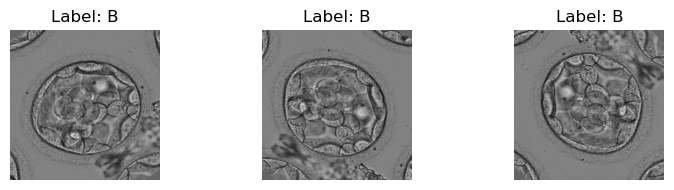

2
2
2


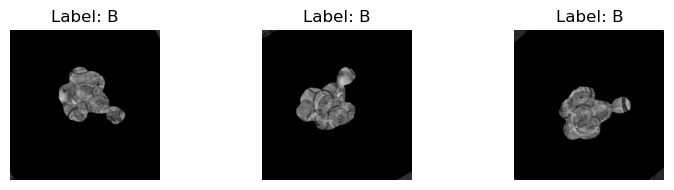

In [81]:
plot_sample_image(2, InstancedEmbryoDataset)  # Plotting a sample image at index 2 from the EmbryoDataset

plot_sample_image(2, InstancedSegmentedEmbryoDataset)  # Plotting a segmented sample image

# 5) Entrenamiento

## Training setup

In [82]:

# Define el número de pliegues para la validación cruzada
num_folds = 10  # Por ejemplo, utiliza 10-fold cross-validation
num_folds = 2  # O 2 para ir más rápido en la prueba

# Definición de otros hiperparámetros
learning_rate = 0.001
batch_size = 16
num_epochs = 2

# Crea un objeto KFold para dividir tus datos
kf = KFold(n_splits=num_folds, shuffle=True)

# Creación del modelo elegido
model_name = 'vgg16'  # Aquí elige el modelo que quieras utilizar
model = get_pretrained_model(model_name)

# Resto del código para el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Seleccionar el optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Instancio el dataset
region_specific=False #Activates or deactivates choosing only the features of a single region (or all)
region=None           #Chooses region (only if region_specific=True)
InstancedEmbryoDataset = EmbryoDataset(img_dir, y, region_specific, region)

# Loop sobre los pliegues (folds)
for fold, (train_index, val_index) in enumerate(kf.split(InstancedEmbryoDataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Divide los datos en conjunto de entrenamiento y validación para este pliegue
    train_dataset = torch.utils.data.Subset(InstancedEmbryoDataset, train_index)
    valid_dataset = torch.utils.data.Subset(InstancedEmbryoDataset, val_index)

    # Crea los DataLoaders para este pliegue
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_dataset, batch_size=batch_size)

    train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    val_acc = accuracy(val_loader, model, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Validation Acc: {val_acc:.4f}")


Fold 1/2


  0%|          | 0/8 [00:00<?, ?it/s]

163
120
229
67
246
159
107
13
127
118
125
193
11
42
60
248


 12%|█▎        | 1/8 [00:20<02:20, 20.09s/it]

5
72
136
23
2
68
150
222
116
114
153
226
156
79
94
113


 25%|██▌       | 2/8 [00:40<02:01, 20.32s/it]

130
73
87
220
218
4
6
18
41
51
205
91
239
27
128
139


 38%|███▊      | 3/8 [01:00<01:40, 20.17s/it]

49
115
202
39
247
110
146
157
111
61
179
31
43
36
206
140


 50%|█████     | 4/8 [01:21<01:22, 20.53s/it]

32
223
178
137
40
26
22
144
106
197
243
78
191
80
20
181


 62%|██████▎   | 5/8 [01:42<01:01, 20.47s/it]

173
221
141
7
166
147
3
138
164
71
133
29
203
227
83
199


 75%|███████▌  | 6/8 [02:01<00:40, 20.27s/it]

185
155
182
112
209
154
92
169
14
168
149
53
59
16
192
119


 88%|████████▊ | 7/8 [02:21<00:19, 19.99s/it]

142
237
129
152
184
104
196
204
45
47
217
8


100%|██████████| 8/8 [02:37<00:00, 19.63s/it]


Epoch [1/2], Train Loss: 40.3925, Train Acc: 0.3387
Checking accuracy
0
1
9
10
12
15
17
19
21
24
25
28
30
33
34
35
37
38
44
46
48
50
52
54
55
56
57
58
62
63
64
65
66
69
70
74
75
76
77
81
82
84
85
86
88
89
90
93
95
96
97
98
99
100
101
102
103
105
108
109
117
121
122
123
124
126
131
132
134
135
143
145
148
151
158
160
161
162
165
167
170
171
172
174
175
176
177
180
183
186
187
188
189
190
194
195
198
200
201
207
208
210
211
212
213
214
215
216
219
224
225
228
230
231
232
233
234
235
236
238
240
241
242
244
245
Got 86 / 125 correct (68.80%)
Epoch [1/2], Validation Acc: 0.6880
Fold 2/2


  0%|          | 0/8 [00:00<?, ?it/s]

19
85
132
24
190
99
1
108
160
82
88
77
238
208
161
180


 12%|█▎        | 1/8 [00:18<02:12, 18.91s/it]

236
76
212
201
171
86
100
224
38
117
89
187
65
158
69
96


 25%|██▌       | 2/8 [00:39<01:58, 19.74s/it]

64
70
143
15
50
75
37
126
225
194
30
109
12
186
102
17


 38%|███▊      | 3/8 [00:59<01:39, 19.94s/it]

234
95
219
58
188
46
165
55
56
122
151
90
228
66
123
54


 50%|█████     | 4/8 [01:18<01:18, 19.60s/it]

62
124
148
74
28
230
210
81
207
121
93
35
48
33
232
167


 62%|██████▎   | 5/8 [01:37<00:58, 19.44s/it]

172
245
242
10
198
0
21
177
170
97
215
244
101
145
200
211


 75%|███████▌  | 6/8 [01:57<00:39, 19.64s/it]

175
162
98
233
135
34
84
189
231
235
241
214
105
183
63
131


 88%|████████▊ | 7/8 [02:17<00:19, 19.55s/it]

52
195
25
213
103
240
176
57
174
134
216
44
9


100%|██████████| 8/8 [02:32<00:00, 19.06s/it]


Epoch [2/2], Train Loss: 1.2914, Train Acc: 0.5360
Checking accuracy
2
3
4
5
6
7
8
11
13
14
16
18
20
22
23
26
27
29
31
32
36
39
40
41
42
43
45
47
49
51
53
59
60
61
67
68
71
72
73
78
79
80
83
87
91
92
94
104
106
107
110
111
112
113
114
115
116
118
119
120
125
127
128
129
130
133
136
137
138
139
140
141
142
144
146
147
149
150
152
153
154
155
156
157
159
163
164
166
168
169
173
178
179
181
182
184
185
191
192
193
196
197
199
202
203
204
205
206
209
217
218
220
221
222
223
226
227
229
237
239
243
246
247
248
Got 81 / 124 correct (65.32%)
Epoch [2/2], Validation Acc: 0.6532
